# Tests on Bandit with Non-Stationary Context Distribution
Here we will test the library [IS_non_stationary_RL](https://github.com/pierresdr/IS_non_stationary_RL) to evaluate and optimize the Non-Stationary Contextual Bandit.
The in the library is defined the custom environment with a non-stationary context distribution. The environment behaviour is explained at the beginning of [NS_contextual bandits.ipynb](./non-stat_contextual_bandits.ipynb), which contains different tests of similar environments.

In [2]:
# 'autoreload' allows to update modules without resetting the kernel 
%load_ext autoreload
%autoreload 2

In [143]:
# Import 'IS_Non-Stationary_RL' library
import sys
sys.path.append('../../IS_non_stationary_RL/')

from policy import Hyperpolicy, Policy
from env.contextual_bandits import ContextualBandit
from importance_sampling.mis_balance_heuristic import MIS_bh_estimation, MIS_bh_variance

# Import other libraries
from tqdm import tqdm
import argparse
import numpy as np
import matplotlib.pyplot as plt

 ## Define and test the optimal policy

In [161]:
def play_nu(nu, env, n_steps):

    contexts = np.zeros(n_steps)
    thetas   = np.zeros(n_steps)
    rewards  = np.zeros(n_steps)
    actions  = np.zeros(n_steps)
    non_stat_process = np.zeros(n_steps)
    theta_means      = np.zeros(n_steps)
    
    x_t = env.reset()
    for t in range(n_steps):
        
        policy = nu.sample_policy(t)

        contexts[t] = x_t
        thetas[t] = policy.theta
        
        # Perform a step sampling the action from current policy 
        action = policy.sample_action(x_t)
        x_t, r_t = env.step(action)
        
        rewards[t] = r_t
        actions[t] = action
        non_stat_process[t] = env.non_stat_process(t)
        theta_means[t] = nu.theta_mean(t)

    #return MIS_bh_estimation(nu, thetas, rewards, alpha=n_steps, beta=1)
    return contexts, thetas, rewards, actions, non_stat_process, theta_means

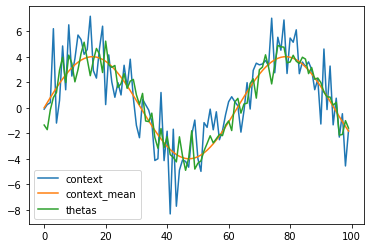

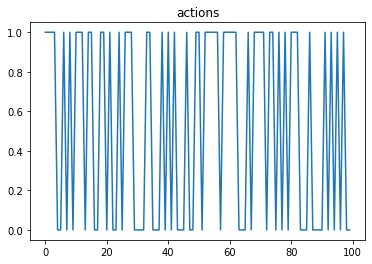

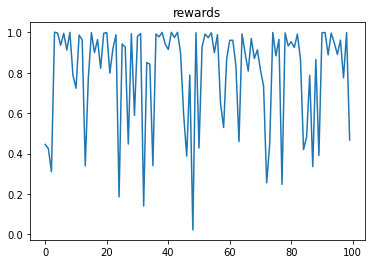

In [162]:
nu = Hyperpolicy(Policy, sigma_theta=1, A=4, psi=0, phi=0.1) 
env = ContextualBandit(mean_reward=True, sigma_x=2, A=4, psi=0, phi=0.1) 

contexts, thetas, rewards, actions, non_stat_process, theta_means = play_nu(nu, env, 100)

plt.plot(contexts, label='context')
plt.plot(non_stat_process, label='context_mean')
plt.plot(thetas, label='thetas')
plt.legend()
plt.show()

plt.plot(actions)
plt.title('actions')
plt.show()

plt.plot(rewards)
plt.title('rewards')
plt.show()

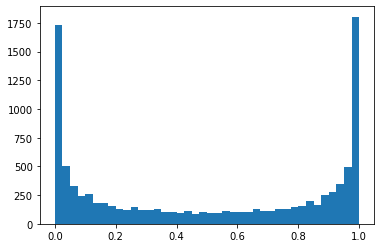

In [164]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

env = ContextualBandit(mean_reward=True, sigma_x=5, A=10, psi=0, phi=0.1) 
x=np.array([(env.sample_x(0)-env.mean_x(0))*4 / env.sigma_x for i in range(10000)])
plt.hist(sigmoid(x), bins=40)
plt.show()

## Test MIS estimator with BH

In [ ]:
### Compute average IS weights (t=251 for 0, t=236 for max)
t = 236
alpha = t
replicas = 10
all_IS_weights = np.zeros((replicas, alpha))

# Initialize hyperpolicy and env
nu = Hyperpolicy(Policy, sigma_theta=1, A=3, psi=0, phi=0.1) 
env = ContextualBandit(mean_reward=True, sigma_x=1, A=3, psi=0, phi=0.1) 

for i in tqdm(range(replicas)):    
    
    env.reset()
    contexts, thetas, rewards, actions, NS_process, theta_means = env.play(nu, n_steps=t, get_p=get_p)
    
    # Evaluate the performance 
    all_IS_weights[i] = MIS_bh_estimation(nu, thetas, rewards, alpha, beta=1)[0]

## MIS as a function of A (of both env and nu)
Now that the context are sampled from the non-stat distribution, the optimal policy needs to 

In [141]:
#### Problem settings ####
param_based = True
R_inf = 1
alpha = 126
range_A = np.linspace(1,5,20)
#A_sigma_ratios = np.linspace(0.1,3,30)
n_seeds = 20
##########################

perf_NS = []
perf_MIS = []
var_MIS = []

for A in tqdm(range_A):
    temp_perf_NS = []
    temp_perf_MIS = []
    temp_var_MIS = []
    
    nu = Hyperpolicy(Policy, sigma_theta=1, A=A, psi=0, phi=0.1) 
    env = ContextualBandit(mean_reward=True, sigma_x=1, A=A, psi=0, phi=0.1) 

    for s in range(n_seeds):
        
        env.reset()
        contexts, thetas, rewards, actions, NS_process, theta_means = play_nu(nu, env, alpha)
        
        temp_perf_NS.append(np.mean(rewards[-alpha:]))
        temp_perf_MIS.append(MIS_bh_estimation(nu, thetas, rewards, alpha, beta=1)[1]*alpha)
        temp_var_MIS.append(MIS_bh_variance(nu, thetas, rewards, R_inf, alpha, beta=1))
        
    perf_NS.append(np.array(temp_perf_NS))
    perf_MIS.append(np.array(temp_perf_MIS))
    var_MIS.append(np.array(temp_var_MIS))
        
perf_NS = np.array(perf_NS)
perf_MIS = np.array(perf_MIS)
var_MIS = np.array(var_MIS)

100%|██████████| 20/20 [00:42<00:00,  2.13s/it]


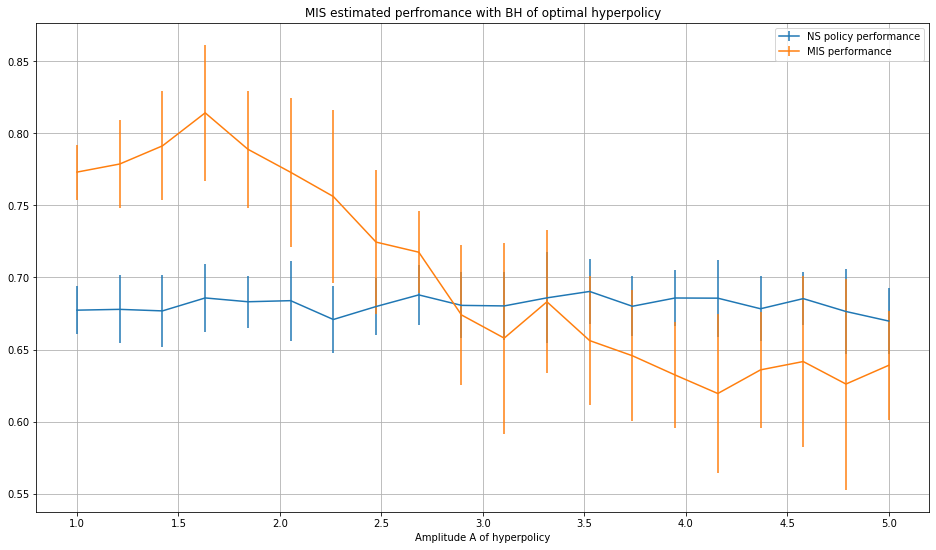

In [142]:
fig, ax = plt.subplots(figsize=(16,9))
ax.errorbar(range_A, perf_NS.mean(axis=1), yerr=perf_NS.std(axis=1), label='NS policy performance')
ax.errorbar(range_A, perf_MIS.mean(axis=1), yerr=perf_MIS.std(axis=1), label='MIS performance')
#ax.errorbar(range_A, var_MIS.mean(axis=1), yerr=var_MIS.std(axis=1), label='MIS variance')
ax.grid()
ax.set_xlabel('Amplitude A of hyperpolicy')
ax.legend()
plt.title('MIS estimated perfromance with BH of optimal hyperpolicy')
plt.show()

## MIS as a function of sigma theta

In [153]:
#### Problem settings ####
param_based = True
R_inf = 1
alpha = 126
range_sigma = np.linspace(0.1,4,20)
#A_sigma_ratios = np.linspace(0.1,3,30)
n_seeds = 20
##########################

perf_NS = []
perf_MIS = []
var_MIS = []

for sigma in tqdm(range_sigma):
    temp_perf_NS = []
    temp_perf_MIS = []
    temp_var_MIS = []
    
    nu = Hyperpolicy(Policy, sigma_theta=sigma, A=5, psi=0, phi=0.1) 
    env = ContextualBandit(mean_reward=True, sigma_x=1, A=5, psi=0, phi=0.1) 

    for s in range(n_seeds):
        
        env.reset()
        contexts, thetas, rewards, actions, NS_process, theta_means = play_nu(nu, env, alpha)
        
        temp_perf_NS.append(np.mean(rewards[-alpha:]))
        temp_perf_MIS.append(MIS_bh_estimation(nu, thetas, rewards, alpha, beta=1)[1]*alpha)
        temp_var_MIS.append(MIS_bh_variance(nu, thetas, rewards, R_inf, alpha, beta=1))
        
    perf_NS.append(np.array(temp_perf_NS))
    perf_MIS.append(np.array(temp_perf_MIS))
    var_MIS.append(np.array(temp_var_MIS))
        
perf_NS = np.array(perf_NS)
perf_MIS = np.array(perf_MIS)
var_MIS = np.array(var_MIS)

100%|██████████| 20/20 [00:38<00:00,  1.94s/it]


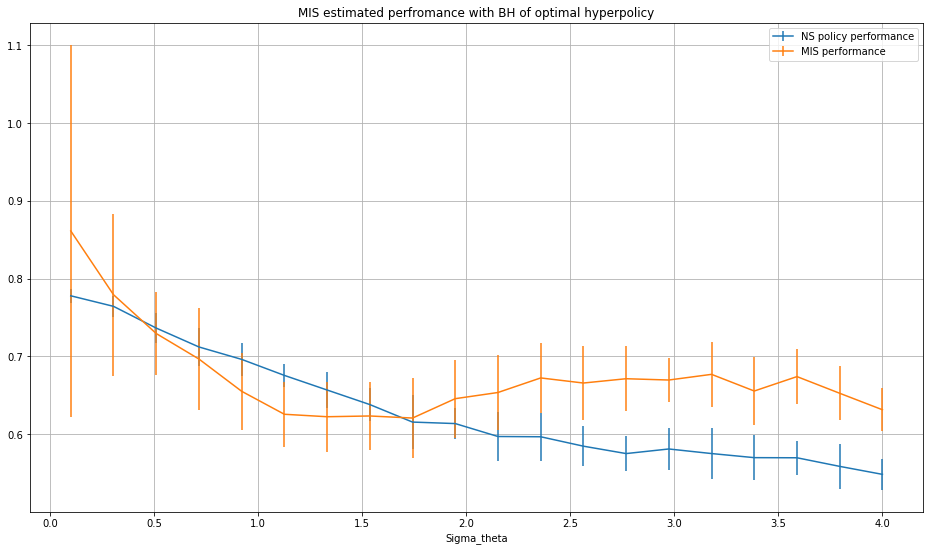

In [154]:
fig, ax = plt.subplots(figsize=(16,9))
ax.errorbar(range_sigma, perf_NS.mean(axis=1), yerr=perf_NS.std(axis=1), label='NS policy performance')
ax.errorbar(range_sigma, perf_MIS.mean(axis=1), yerr=perf_MIS.std(axis=1), label='MIS performance')
#ax.errorbar(range_sigma, var_MIS.mean(axis=1), yerr=var_MIS.std(axis=1), label='MIS variance')
ax.grid()
ax.set_xlabel('Sigma_theta')
ax.legend()
plt.title('MIS estimated perfromance with BH of optimal hyperpolicy')
plt.show()